# Execute SpykProps on a folder with images

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# cd '/content/drive/MyDrive/M.Sc/THESIS/ImageAnalysis/SpikeProperties/Spyk_Prop'

/content/drive/MyDrive/M.Sc/THESIS/ImageAnalysis/SpikeProperties/Spyk_Prop


In [3]:
# pip install skan

In [4]:
# import sys
# sys.path.append('/content/drive/MyDrive/M.Sc/THESIS/ImageAnalysis/SpikeProperties/Spyk_Prop')
# sys.path

['',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/drive/MyDrive/M.Sc/THESIS/ImageAnalysis/SpikeProperties/Spyk_Prop']

## Define the function

In [1]:
def SpykBatch(Images, TROE2020=False):
    
    import time
    start_time = time.time()
    
    Nimages = str(len(Images))
    
    Spikes_data = pd.DataFrame()
    Contours_data = pd.DataFrame()
    Spklts_data = pd.DataFrame()
    Distances_data = pd.DataFrame()
    
    Counter=0


    for img_name in Images:
        
        try:

            Counter = Counter+1
            Progress = str(Counter) + "/" + Nimages
            # img_name=Images[0]
            print("Processing image " + Progress + ": ", img_name)

            # Set the initial time per image
            image_time = time.time()

            # Remove background and create images
            I = RemoveBackground(img_name, OtsuScaling=0.25, rgb_out=True, gray_out=True, lab_out=True, hsv_out=True, bw_out=True)
            rgb0 = I[0]
            gray0 = I[1]
            lab0 = I[2]
            hsv0 = I[3]
            bw0 = I[4]

            # Enumerate spikes
        #     EnumerateSpkCV(bw0, rgb0, TextSize=5, TROE2020=False)

            # Collect spikes data
            df = SpikesDF(I=I, ImagePath=img_name, RemoveBG=False, rm_envelope=False)

            # Label spikes
            labeled_spks, num_spikes = label(bw0, return_num = True)
            # plt.imshow(labeled_spks==1)

            # Spike lengths
            SpkLengths = []

            # Spike distances from each other
            SpkDists = []

            # TROE2021 and PGR start at 2. Ignore background (0) and envelope (1)
            # if TROE2020==False:
            #     FirstSpk = 2
            # else:
            #     FirstSpk = 1


            ContoursPerSpk = pd.DataFrame()
            SpkltsPerSpk = pd.DataFrame()
            DistancesPerSpk = pd.DataFrame()    



            # Start at so it ignores background (0) 
            for Label in range(1, num_spikes+1):
                
                try:
                    print("Processing spike ", Label)
            #         plt.imshow(labeled_spks==2)

                    spk = labeled_spks==Label
                    # plt.imshow(spk)

                    # Crop spike
                    slice_x, slice_y = ndimage.find_objects(spk)[0]
                    cropped_spk = spk[slice_x, slice_y]
                    cropped_rgb = rgb0[slice_x, slice_y]
                    cropped_rgb = np.where(cropped_spk[..., None], cropped_rgb, 0)
                    cropped_gray = color.rgb2gray(cropped_rgb)
                    cropped_lab = color.rgb2lab(cropped_rgb)
                    cropped_hsv = color.rgb2hsv(cropped_rgb)
            #         plt.imshow(cropped_spk)

                    # Spike length
                    sl = spk_length(cropped_spk, method='skelblur', Overlay=False, PlotCH=False)
                    SpkLengths.append(sl)

                    # Theshold for detection
                    thresh2 = SpkltThresh(cropped_rgb, ResizeFactor=30, thr2=0.8, MinSize=1000)
                    # plt.imshow(thresh2)

                    # Distances between contours
                    D = DistAll(bw=thresh2, HeatMap=False, spike_length=sl)
                    SpkDists.append(D)
                    # Image_Name = [img_name.split('\\')[-1]]
                    # DistMat = pd.DataFrame(list(zip(Image_Name, str(Label), D)), columns = ['Image_Name', 'Spike_Label', 'MatrixD'])

                    # Contours
                    labels_cont = CountorProps(cropped_rgb, cropped_lab, cropped_hsv, thresh2, ImagePath=img_name, ResizeFactor=30, MinSize = 1000, thr2=0.8, plot=False)
                    # Add spike label
                    labels_cont['Spike_Label'] = [str(Label)] * len(labels_cont)

                    # Watershed segments
                    spklts, n_spklts= LabelSpklts(cropped_rgb, MinDist=50, labels_out=True, n_spklt=True, Plot=False)
                    WSProps = ObjProps(labeled=spklts, cropped_rgb=cropped_rgb, cropped_lab=cropped_lab, cropped_hsv=cropped_hsv, ImagePath=img_name, MinSize = 5000)
                    # Add spike label
                    WSProps['Spike_Label'] = [str(Label)] * len(WSProps)

                    ContoursPerSpk = ContoursPerSpk.append(labels_cont)
                    SpkltsPerSpk = SpkltsPerSpk.append(WSProps)
                   
                    # DistancesPerSpk = DistancesPerSpk.append(DistMat)
                    
                except:
                    pass

            Contours_data = Contours_data.append(ContoursPerSpk)
            Spklts_data = Spklts_data.append(SpkltsPerSpk)
            # Distances_data = Distances_data.append(SpkDists)


            # Add spike lengths and append current data frame
            df["SpykLength"] = SpkLengths
            Spikes_data = Spikes_data.append(df)

            # Distances matrix

            # Create columns with image name, spike index, and distances matrix
            Image_Name = img_name.split('\\')[-1]
            Image_Name = [Image_Name] * len(SpkDists)
            Spk_Index = [number for number in range(1, num_spikes+1)]
            # Matrix of distances among detected spikelets
            DistMat = pd.DataFrame(list(zip(Image_Name, Spk_Index, SpkDists)), columns = ['Image_Name', 'Spike_Label', 'MatrixD'])
            # Append
            Distances_data = Distances_data.append(DistMat)

            # How long did it take to run this image?
            print("Image " + img_name.split('\\')[-1] + ", " + Progress + ", was fully processed in " + str(round(time.time() - image_time, 1)) + " seconds." + "\n")
            
        except:
            pass

    # How long did it take to run the whole code?
    print("This entire code took", str(round(time.time() - start_time, 1)), "seconds to run.")
    
    return Spikes_data, Contours_data, Spklts_data, Distances_data


## Batch execution

In [ ]:
%%time

from SpykFunctions import *

path = r'./Images/PGR_Roseau2021'
Images = ListImages(path, imgformat=".tif", recursive=False)

Spikes_data, Contours_data, Spklts_data, Distances_data = SpykBatch(Images, TROE2020=False)


## Export datasets

In [8]:
# Spikes_data, Contours_data, Spklts_data, Distances_data 

Spikes_data.to_csv(".\Output\Roseau2021_SpikeData_20211031.csv", index=False)
Contours_data.to_csv(".\Output\Roseau2021_ContoursData_20211031.csv", index=False)
Spklts_data.to_csv(".\Output\Roseau2021_SpkltsData_20211031.csv", index=False)
Distances_data.to_csv(".\Output\Roseau2021_DistancesData_20211031.csv", index=False)




In [9]:
%%time

from SpykFunctions import *

path = r'./Images/PGR_Roseau2021'
Images= ListImages(path, imgformat=".tif", recursive=False)

# ./Images/PGR_Roseau2021\S2p03T2R1.tif

Spikes_data, Contours_data, Spklts_data, Distances_data = SpykBatch([Images[39]], TROE2020=False)


Processing image 1/1:  ./Images/PGR_Roseau2021\S2p03T2R1.tif
Processing spike  1
Processing spike  2
Processing spike  3
Processing spike  4
Processing spike  5
Processing spike  6
Processing spike  7
Processing spike  8
Processing spike  9
Processing spike  10
Processing spike  11
Processing spike  12
Processing spike  13
Processing spike  14
Processing spike  15
Processing spike  16
Processing spike  17
Processing spike  18
Image S2p03T2R1.tif, 1/1, was fully processed in 121.1 seconds.

This entire code took 121.1 seconds to run.
Wall time: 2min 1s


# Detect fake spikes

In [12]:
# %%time

from SpykFunctions import *

path = r'./Images/PGR_Roseau2021'
Images = ListImages(path, imgformat=".tif", recursive=False)

img = Images[3]



Wall time: 4.98 s


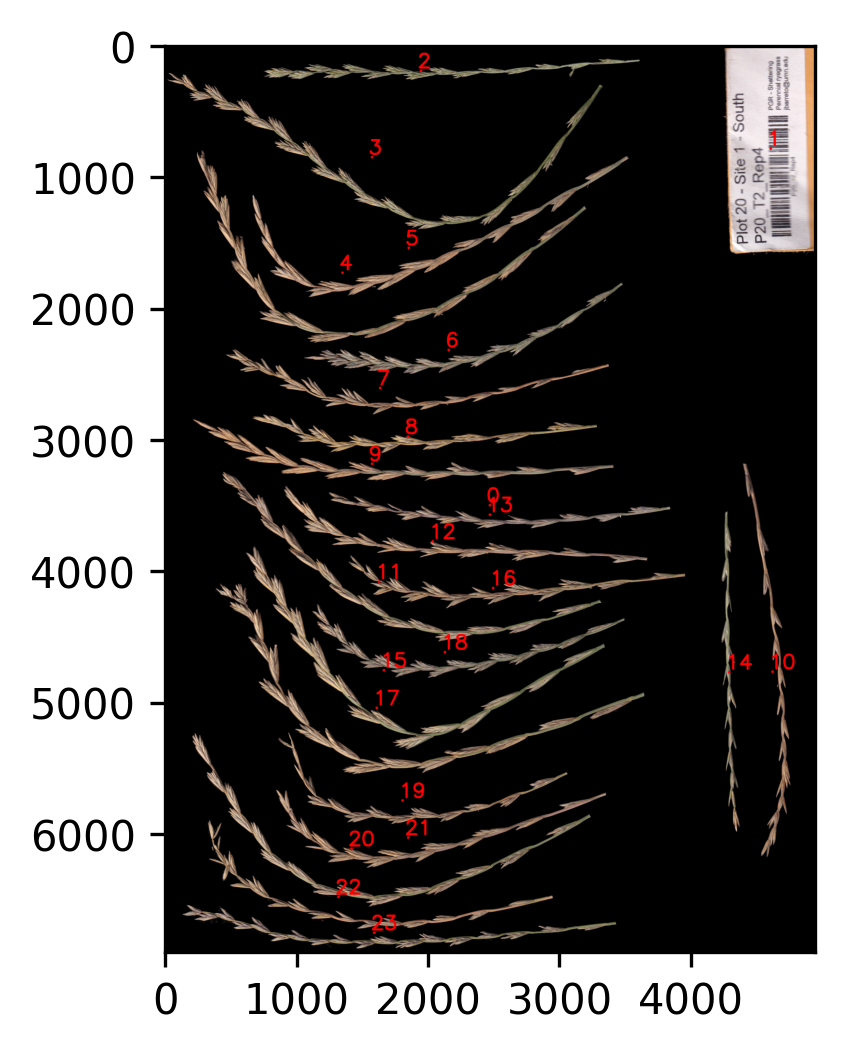

In [61]:
%%time

img_name = './Images/PGR_Roseau2021\\S1p20T2R4.tif'
# plt.imshow(plt.imread(img_name))

# Remove background and create images
I = RemoveBackground(img_name, OtsuScaling=0.25, rgb_out=True, gray_out=False, lab_out=False, hsv_out=False, bw_out=True)
rgb0 = I[0]
bw0 = I[1]
# gray0 = I[1]
# lab0 = I[2]
# hsv0 = I[3]
# bw0 = I[4]

plt.rcParams['figure.dpi'] = 300

# Enumerate spikes
EnumerateSpkCV(bw0, rgb0, TextSize=5, TROE2020=False)



In [ ]:
## Fake spikes
S1p08T3R2.tif = 21, 23
S1p10T4R2.tif = 22
S1p12T3R3.tif = 19, 21


# Enumerate all images

In [46]:
def EnumBatch(Images, TROE2020=False, TextSize=3):
    
    import time
    start_time = time.time()
    
    Nimages = str(len(Images))
    Counter=0
    
    for img_name in Images:

        Counter = Counter+1
        Progress = str(Counter) + "/" + Nimages
        # img_name=Images[0]
        print("Enumerating image " + Progress + ": ", img_name)

        # Set the initial time per image
        image_time = time.time()

        # Remove background and create images
        I = RemoveBackground(img_name, OtsuScaling=0.25, rgb_out=True, gray_out=False, lab_out=False, hsv_out=False, bw_out=True)
        rgb0 = I[0]
        bw0 = I[1]

        EnumPlot = EnumerateSpkCV(bw0, rgb0, TextSize=TextSize, TROE2020=False, Plot=False, PlotOut=True)
        ThisImage = img_name.split('/')[-1:]
        plotname = '.\Images\ENUMERATED\\' + ThisImage[0] + '.jpg'
        plt.imsave(plotname, EnumPlot)           

        # How long did it take to run this image?
        print("Image " + img_name.split('\\')[-1] + ", " + Progress + ", was enumerated in " + str(round(time.time() - image_time, 1)) + " seconds." + "\n")
            
            
    # How long did it take to run the whole code?
    print("This entire code took", str(round(time.time() - start_time, 1)), "seconds to run.")
    


## Enumerate PGR Roseau2021

In [ ]:
%%time
path = r'./Images/PGR_Roseau2021'
Images = ListImages(path, imgformat=".tif", recursive=False)

EnumBatch(Images, TROE2020=False, TextSize=3)
# Finished in about 4min (236.7 sec)

## Enumerate TROE2021

In [ ]:
%%time
path = r'./Images/TROE2021'
Images = ListImages(path, imgformat=".tif", recursive=False)

EnumBatch(Images, TROE2020=False, TextSize=3)
# Finished in over 2h and 7min  ( 7638.1 sec)

# Gifs
Gifs for presentations

In [2]:
pip install imutils

  Using cached imutils-0.5.4-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [8]:
from SpykFunctions import *
path = r'./Images/PGR_Roseau2021'
Images = ListImages(path, imgformat=".tif", recursive=False)
# img = Images['S1p14T4R3.tif']
img = [s for s in Images if "S1p15T5R3" in s]
img = img[0]

## Remove Background

In [13]:
%%time

# Remove Backgrouns
OtsuScaling=0.25
rgb_out=True
gray_out=True
lab_out=True
hsv_out=True

img0 = plt.imread(img)


# Crop images. They were all taken with the same scanner
img1 = img0[44:6940, 25:4970, :]

plt.imsave('.\GIFS\CSSA\Spikes\\01_RGBoriginal.jpg',img1)

 # Convert to gray
gray0 = img1 @ [0.2126, 0.7152, 0.0722]

plt.imsave('.\GIFS\CSSA\Spikes\\02_GRAYoriginal.jpg',gray0, cmap='gray')

# Set image threshold
T = filters.threshold_otsu(gray0)
#     print(T)
T = T*OtsuScaling
#     print(T)

# Segment gray image
bw0 = gray0 > T

plt.imsave('.\GIFS\CSSA\Spikes\\03_BWoriginal.jpg', bw0, cmap='gray')

# Remove small objects
n_pixels = gray0.shape[0] * gray0.shape[1]
minimum_size = n_pixels/10000
bw1 = morphology.remove_small_objects(bw0, min_size=np.floor(minimum_size))

plt.imsave('.\GIFS\CSSA\Spikes\\04_BW1original.jpg', bw1, cmap='gray')


if rgb_out==True:
    # Apply mask to RGB
    rgb = np.where(bw1[..., None], img1, 0)
    plt.imsave('.\GIFS\CSSA\Spikes\\05_ThreshRGB.jpg', rgb)
if gray_out==True and rgb_out==True:
    gray = color.rgb2gray(rgb)
    plt.imsave('.\GIFS\CSSA\Spikes\\06_ThreshGRAY.jpg', gray, cmap='gray')
# if lab_out==True and rgb_out==True:
    # lab = color.rgb2lab(rgb)
    # plt.imsave('.\GIFS\CSSA\Spikes\\07_ThreshLAB.jpg', lab)
if hsv_out==True and rgb_out==True:
    hsv = color.rgb2hsv(rgb)
    plt.imsave('.\GIFS\CSSA\Spikes\\08_ThreshHSV.jpg', hsv)




Wall time: 31.9 s


## Enumerate

In [14]:
%%time

TextSize = 5
nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(np.uint8(bw1), connectivity=8)
img = rgb.copy()

counter=0
for c in centroids:
#         print(c)
    cx = round(c[0])
    cy = round(c[1])
    img = cv2.circle(img, (cx, cy), 10, (255, 0, 0), -1)
    img = cv2.putText(img, str(counter), (cx - 25, cy - 25),cv2.FONT_HERSHEY_SIMPLEX, TextSize, (255, 0, 0), 15)
    counter = counter+1

    if len(str(counter)) < 2:
        thisContour = '0' + str(counter)
    else:
        thisContour = str(counter)
    plotname = '.\GIFS\CSSA\Spikes\\09_enumerate_' + thisContour + '.jpg'
    plt.imsave(plotname, img)
    # plt.imshow(img)


Wall time: 17 s


In [11]:
# %%time
# EnumPlot = EnumerateSpkCV(bw1, rgb, TextSize=5, TROE2020=False, Plot=False, PlotOut=True)
# plotname = '.\GIFS\CSSA\Spikes\\10_enumerate_' + thisContour + '.jpg'
# plt.imsave(plotname, img)

## Select a spike

In [20]:
%%time

# Label spikes
labeled_spks, num_spikes = label(bw1, return_num = True)
# plt.imshow(labeled_spks==1)

Label = 8

spk = labeled_spks==Label
# plt.imshow(spk, cmap='gray')
plotname = '.\GIFS\CSSA\Spikes\\10_SelectedSpike_' + str(Label) + '.jpg'
plt.imsave(plotname, spk, cmap='gray')

# Crop spike
slice_x, slice_y = ndimage.find_objects(spk)[0]
cropped_spk = spk[slice_x, slice_y]
cropped_rgb = rgb[slice_x, slice_y]
cropped_rgb = np.where(cropped_spk[..., None], cropped_rgb, 0)
cropped_gray = color.rgb2gray(cropped_rgb)
cropped_lab = color.rgb2lab(cropped_rgb)
cropped_hsv = color.rgb2hsv(cropped_rgb)

plotname = '.\GIFS\CSSA\Spike\\01_rgb.jpg'
plt.imsave(plotname, cropped_rgb)
plotname = '.\GIFS\CSSA\Spike\\02_gray.jpg'
plt.imsave(plotname, cropped_gray, cmap='gray')
# plotname = '.\GIFS\CSSA\Spike\\03_lab.jpg'
# plt.imsave(plotname, cropped_lab)
plotname = '.\GIFS\CSSA\Spike\\04_hsv.jpg'
plt.imsave(plotname, cropped_hsv)
plotname = '.\GIFS\CSSA\Spike\\05_bw.jpg'
plt.imsave(plotname, cropped_spk, cmap='gray')


Wall time: 2.71 s


## Spike Length

Wall time: 334 ms


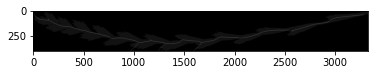

In [21]:
%%time
def spk_length(cropped_spk, method='skelblur', Overlay=True, PlotCH=False, PlotOut=False):
    
    if method=='skelblur':
        # Severly blur the image
        blur = cv2.blur(np.float32(cropped_spk),(100,100))
        # Threshold the blur
        thrb = blur > 0.1
        skeleton = skeletonize(thrb)
#         plt.imshow(skeleton)
        
    if method=='chull':
        # Blur the image with a 50x50 kernel
        blur = cv2.blur(np.float32(cropped_spk),(50,50))

        # Get convex hull 
        chull = convex_hull_image(blur>0)

        # Perform skeletonization
        image = chull
        skeleton = skeletonize(image)
    #     plt.imshow(skeleton)
    
    # Spike length
    SpkL = cv2.countNonZero(np.float32(skeleton))
    
    if PlotCH == True:
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))
        ax = axes.ravel()

        ax[0].set_title('Original picture')
        ax[0].imshow(cropped_spk, cmap=plt.cm.gray)
        ax[0].set_axis_off()

        ax[1].set_title('Transformed picture')
        ax[1].imshow(chull, cmap=plt.cm.gray)
        ax[1].set_axis_off()

        plt.tight_layout()
        plt.show()
    
    # Visualize overlay?
    if Overlay == True:
        overlay_images = cv2.addWeighted(np.float32(cropped_spk),20,np.float32(skeleton),255,0)
        plt.imshow(overlay_images, cmap='gray')
    
    if PlotOut==True:
        overlay_images = cv2.addWeighted(np.float32(cropped_spk),20,np.float32(skeleton),255,0)
        return SpkL, overlay_images
    else:
        return SpkL

# Example:
SL, SLplot = spk_length(cropped_spk, method='skelblur', Overlay=False, PlotCH=False, PlotOut=True)
plt.imshow(SLplot, cmap='gray')
# SL = spk_length(cropped_spk, method='skelblur', Overlay=True, PlotCH=False)

In [22]:
%%time

plotname = '.\GIFS\CSSA\Spike\spk_length\\06_bw.jpg'
plt.imsave(plotname, cropped_spk, cmap='gray')

# Severly blur the image
blur = cv2.blur(np.float32(cropped_spk),(100,100))
plotname = '.\GIFS\CSSA\Spike\spk_length\\07_bw_blur.jpg'
plt.imsave(plotname, blur, cmap='gray')

# Threshold the blur
thrb = blur > 0.1
plotname = '.\GIFS\CSSA\Spike\spk_length\\08_bw_thrb.jpg'
plt.imsave(plotname, thrb, cmap='gray')

# Create skeleton
skeleton = skeletonize(thrb)
plotname = '.\GIFS\CSSA\Spike\spk_length\\09_bw_skel.jpg'
plt.imsave(plotname, skeleton, cmap='gray')

# Overlay skeleton
overlay_images = cv2.addWeighted(np.float32(cropped_spk),20,np.float32(skeleton),255,0)
plotname = '.\GIFS\CSSA\Spike\spk_length\\10_bw_SkelOverlay.jpg'
plt.imsave(plotname, overlay_images, cmap='gray')

Wall time: 727 ms


## Treshold for contrours

In [28]:
%%time

ResizeFactor=30
thr2=0.8
MinSize=1000

plotname = '.\GIFS\CSSA\Spike\\thresh2\\11_bw.jpg'
plt.imsave(plotname, cropped_spk, cmap='gray')

# Reduce image size
im = Image.fromarray((cropped_gray*255).astype(np.uint8))
(width, height) = (im.width // ResizeFactor, im.height // ResizeFactor)
rescaled_spk = im.resize((width, height))
plotname = '.\GIFS\CSSA\Spike\\thresh2\\12_bw_resized.jpg'
plt.imsave(plotname, np.asarray(rescaled_spk), cmap='gray')


# Increase to original size
(width, height) = (im.width, im.height)
rescaled_spk = rescaled_spk.resize((width, height))
rescaled_spk = np.asarray(rescaled_spk)
plotname = '.\GIFS\CSSA\Spike\\thresh2\\13_bw_SizeRestored.jpg'
plt.imsave(plotname, rescaled_spk, cmap='gray')

# Histogram equalization
rescaled_spk = exposure.equalize_hist(rescaled_spk)
plotname = '.\GIFS\CSSA\Spike\\thresh2\\14_bw_HistEq.jpg'
plt.imsave(plotname, rescaled_spk, cmap='gray')

# Blur with a Gaussian
blurred = filters.gaussian(rescaled_spk, sigma=1, preserve_range=True)
plotname = '.\GIFS\CSSA\Spike\\thresh2\\15_bw_GaussBlur.jpg'
plt.imsave(plotname, blurred, cmap='gray')

# Adaptative equalization
blurred = exposure.equalize_adapthist(blurred)
plotname = '.\GIFS\CSSA\Spike\\thresh2\\16_bw_AdaptHist.jpg'
plt.imsave(plotname, blurred, cmap='gray')

# Normalize
blurred = cv2.normalize(blurred, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
blurred = blurred.astype(np.uint8)

if thr2 < 1 == True:
    thr2 = thr2*255
else:
    thr2 = thr2

# Threshold at given %
ret, thresh = cv2.threshold(blurred, thr2, 255, 0)
thresh = np.uint8(thresh)
plotname = '.\GIFS\CSSA\Spike\\thresh2\\17_bw_thresh.jpg'
plt.imsave(plotname, thresh, cmap='gray')

nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(thresh, connectivity=8)
sizes = stats[1:, -1]; nb_components = nb_components - 1    

thresh2 = np.zeros((output.shape))

# Keep only objects with minimum size
for i in range(0, nb_components):
    if sizes[i] >= MinSize:
        thresh2[output == i + 1] = 255

#     plt.imshow(thresh2)
thresh2 = np.uint8(thresh2)
plotname = '.\GIFS\CSSA\Spike\\thresh2\\18_bw_thresh2.jpg'
plt.imsave(plotname, thresh2, cmap='gray')




Wall time: 988 ms


## Watershed

In [25]:
%%time

plotname = '.\GIFS\CSSA\Spike\Watershed\\01_rgb.jpg'
plt.imsave(plotname, cropped_rgb)

# Rescale to 10% of original
rescaled_spk = rescale(cropped_rgb[...], 0.1, preserve_range=False, multichannel=True, anti_aliasing=True)
# plt.imshow(rescaled_spk)
plotname = '.\GIFS\CSSA\Spike\Watershed\\02_rescaled.jpg'
plt.imsave(plotname, rescaled_spk)


# Erosion
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
erosion = cv2.erode(rescaled_spk,kernel,iterations = 1)
# plt.imshow(erosion)
plotname = '.\GIFS\CSSA\Spike\Watershed\\03_erosion.jpg'
plt.imsave(plotname, erosion)

# Opening
kernel = np.ones((1,1),np.uint8)
opening = cv2.morphologyEx(erosion, cv2.MORPH_OPEN, kernel, iterations = 10)
# plt.imshow(opening)
plotname = '.\GIFS\CSSA\Spike\Watershed\\04_opening.jpg'
plt.imsave(plotname, opening)

# Resize
rescaled_spk2 = Image.fromarray((rescaled_spk * 255).astype(np.uint8))
rescaled_spk2 = rescaled_spk2.resize((cropped_rgb.shape[1],cropped_rgb.shape[0]))
# plt.imshow(rescaled_spk2)
# rescaled_spk2.size
opening = np.asarray(rescaled_spk2)
# plt.imshow(opening)
plotname = '.\GIFS\CSSA\Spike\Watershed\\05_ResizedOpening.jpg'
plt.imsave(plotname, opening)


# Convert rgb to gray
gray_spklts = opening @ [0.2126, 0.7152, 0.0722]
# plt.imshow(gray_spklts)
plotname = '.\GIFS\CSSA\Spike\Watershed\\06_gray.jpg'
plt.imsave(plotname, gray_spklts, cmap='gray')

# Binarize gray
bw_spklts = gray_spklts > 0
# plt.imshow(bw_spklts)
plotname = '.\GIFS\CSSA\Spike\Watershed\\07_binary.jpg'
plt.imsave(plotname, bw_spklts, cmap='gray')

# Get distances
distance = ndi.distance_transform_edt(bw_spklts)
# plt.imshow(-distance)
plotname = '.\GIFS\CSSA\Spike\Watershed\\08_distance.jpg'
plt.imsave(plotname, distance, cmap='gray')

MinDist=50
# Get max peaks
coords = peak_local_max(distance, min_distance=MinDist, labels=bw_spklts)
# plt.imshow(coords)
plotname = '.\GIFS\CSSA\Spike\Watershed\\09_coords.jpg'
plt.imsave(plotname, coords, cmap='gray')

mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, spikelets = ndi.label(mask)
plotname = '.\GIFS\CSSA\Spike\Watershed\\10_markers.jpg'
plt.imsave(plotname, markers, cmap='gray')

# Watershed
labels = watershed(-distance, markers, mask=bw_spklts)
#     plt.imshow(labels)
plotname = '.\GIFS\CSSA\Spike\Watershed\\11_labels.jpg'
plt.imsave(plotname, labels)

labels2 = np.unique(labels[labels > 0])

C = []

for label in labels2:
        y = labels == label
        y = y * 255
        y = y.astype('uint8')
        contours, hierarchy = cv2.findContours(y, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # len(contours)
        contours = np.squeeze(contours)
        C.append(contours)

#         plt.imshow(d[2])

contours = C

OutImage = cropped_rgb.copy()

# Plot all found contours
OutImage = cv2.drawContours(OutImage, contours, -1, (0,0,0), 10);
# plt.imshow(OutImage)

count = 11

for c in contours:
    try:

        # Generate random colors
        random_channels = (np.random.choice(range(256), size=3))
        rr = int(random_channels[0])
        rg = int(random_channels[1])
        rb = int(random_channels[2])

        ellipse = cv2.fitEllipse(c)
        OutImage = cv2.ellipse(OutImage,ellipse,(rr,rg,rb),10);

        count = count+1
        plotname = '.\GIFS\CSSA\Spike\Watershed\\' + str(count) + '_contour.jpg'
        plt.imsave(plotname, OutImage)

        # Fit a line 
        rows,cols = OutImage.shape[:2]
        [vx,vy,x,y] = cv2.fitLine(c, cv2.DIST_L2,0,0.01,0.01);
        lefty = int((-x*vy/vx) + y)
        righty = int(((cols-x)*vy/vx)+y)
        # OutImage = cv2.line(OutImage,(cols-1,righty),(0,lefty),(rr,rg,rb),3);

        # Slope from tope left, which is is the origin [0,0]
        rise = (0,lefty)[1] - (cols-1,righty)[1]
        run = cols
        Slope = rise/run
        Slopes.append(Slope) 
    except:
        pass


Wall time: 3.11 s


Detected spikelets =  18


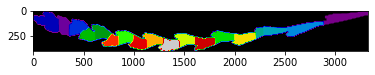

In [26]:
LabelSpklts(cropped_rgb, MinDist=50, labels_out=False, n_spklt=False, ElliPlot=False, Plot=True)

## Distances all

## Contours

In [ ]:
# Contours
labels_cont = CountorProps(cropped_rgb, cropped_lab, cropped_hsv, thresh2, ImagePath=img_name, ResizeFactor=30, MinSize = 1000, thr2=0.8, plot=False)